In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize

## Importing Original Data

In [4]:
#IMPORTING CLEAN DATA USING RANDOM SAMPLING
train = pd.read_csv("projectData/train.csv", index_col=0)
train

,NEO_REFERENCE_ID,EST_DIA_IN_M(MIN),EST_DIA_IN_M(MAX),RELATIVE_VELOCITY_KM_PER_SEC,MISS_DIST.(KILOMETERS),PERIHELION_DISTANCE,APHELION_DIST,PERIHELION_TIME,MEAN_ANOMALY,MEAN_MOTION,HAZARDOUS,RISK_CATEGORY
2586,3529625,183.888672,411.187571,9.551351,27837396.0,0.783714,1.338152,2457843.686,141.435423,0.901929,False,1
29,3182169,50.647146,113.250461,3.838017,12937927.0,0.894596,1.275511,2458019.676,343.278084,0.872021,False,0
1677,3256739,253.837029,567.596853,6.477856,72234080.0,1.239713,2.001073,2457878.935,58.087470,0.477830,False,1
1833,3761549,334.622374,748.238376,18.027267,25818802.0,0.993025,1.966328,2458313.630,188.533899,0.547588,True,2
3632,3653520,69.912523,156.329154,24.300910,71082192.0,0.922122,3.114245,2457587.296,142.045632,0.343766,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2972,3648642,29.144390,65.168838,5.792225,6990692.5,0.617199,1.075825,2458100.540,233.401850,1.265477,False,0
3295,3711170,16.016034,35.812940,7.519185,2379111.0,0.982878,2.842302,2458019.666,352.858271,0.372624,False,0
271,3663258,10.581689,23.661375,8.965194,23981302.0,0.567981,1.290169,2457956.558,48.361916,1.100596,False,0
2522,3430406,221.082810,494.356193,5.432581,21529706.0,1.127583,3.110956,2458014.795,355.433174,0.319466,False,1


## Classification of Train by Logistic Regression

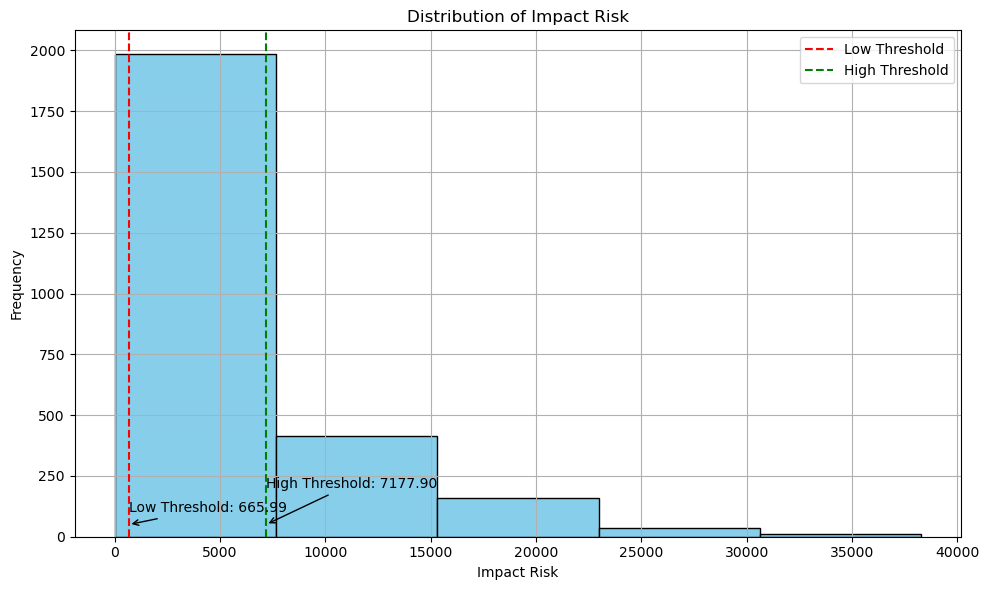

Low Threshold: 665.9877991585269
High Threshold: 7177.898347105189


In [5]:
train['IMPACT_RISK'] = train['EST_DIA_IN_M(MAX)'] * train['RELATIVE_VELOCITY_KM_PER_SEC']

# Check the distribution of IMPACT RISK
risk_values = train['IMPACT_RISK']
risk_values.describe()

# Determine thresholds based on the distribution
low_threshold = risk_values.quantile(0.25)
high_threshold = risk_values.quantile(0.75)

# Plotting the histogram with annotations for thresholds
plt.figure(figsize=(10, 6))
plt.hist(risk_values, bins=5, color='skyblue', edgecolor='black')
plt.axvline(low_threshold, color='r', linestyle='--', label='Low Threshold')
plt.axvline(high_threshold, color='g', linestyle='--', label='High Threshold')
plt.xlabel('Impact Risk')
plt.ylabel('Frequency')
plt.title('Distribution of Impact Risk')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Annotate the thresholds on the histogram
plt.annotate(f'Low Threshold: {low_threshold:.2f}', xy=(low_threshold, 50), xytext=(low_threshold + 5, 100),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate(f'High Threshold: {high_threshold:.2f}', xy=(high_threshold, 50), xytext=(high_threshold - 10, 200),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

print('Low Threshold:', low_threshold)
print('High Threshold:', high_threshold)

# Create a new column 'Impact Risk Category' based on calculated thresholds
train['IMPACT_RISK_CATEGORY'] = pd.cut(train['IMPACT_RISK'], bins=[-np.inf, low_threshold, high_threshold, np.inf],labels=['Low', 'Medium', 'High'])


In [6]:
# Encoding the target variable (IMPACT RISK CATEGORY)
le = LabelEncoder()
train['IMPACT_RISK_ENCODED'] = le.fit_transform(train['IMPACT_RISK_CATEGORY'])

# Convert Hazardous to encoded
train['HAZARDOUS_ENCODED'] = train['HAZARDOUS'].astype(int)

# Features and target preparation
X = train[['IMPACT_RISK','HAZARDOUS_ENCODED']]
y = train['IMPACT_RISK_ENCODED']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

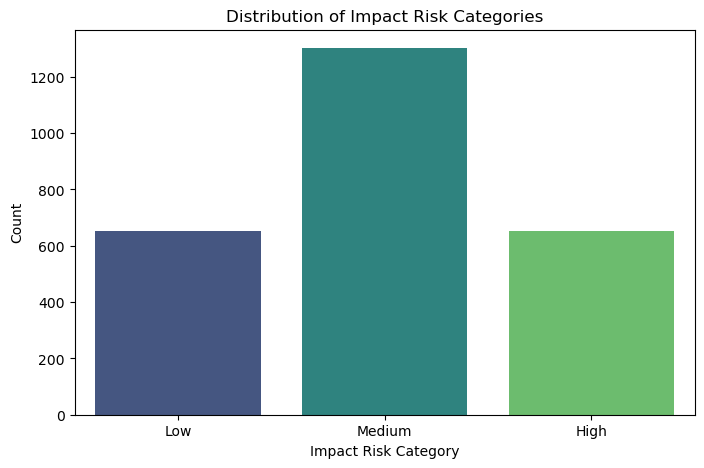

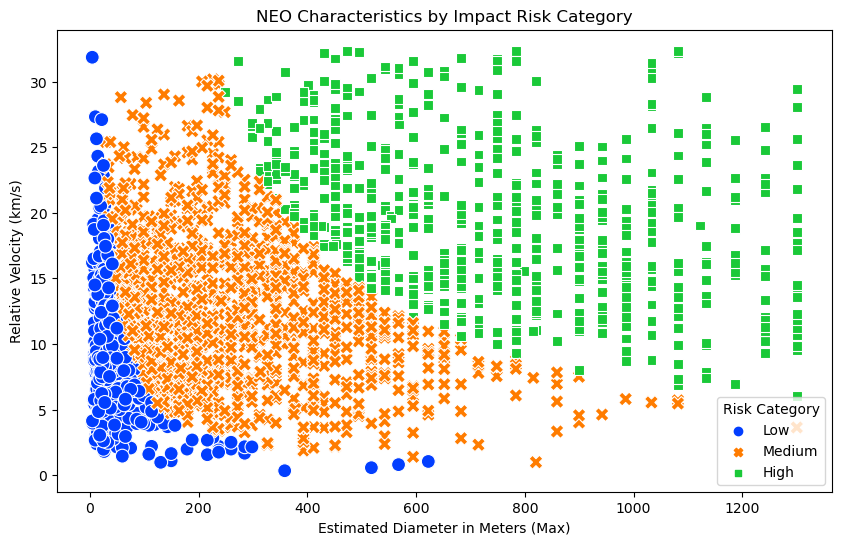

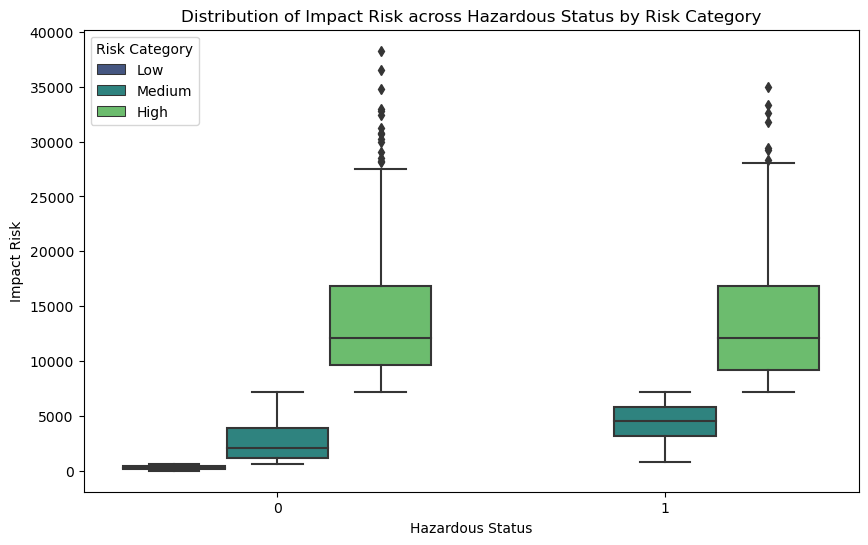

In [7]:
# Histogram of Impact Risk Categories
plt.figure(figsize=(8, 5))
sb.countplot(x='IMPACT_RISK_CATEGORY', data=train, palette='viridis')
plt.title('Distribution of Impact Risk Categories')
plt.xlabel('Impact Risk Category')
plt.ylabel('Count')
plt.show()

# Scatter Plot with Categories
plt.figure(figsize=(10, 6))
sb.scatterplot(data=train, x='EST_DIA_IN_M(MAX)', y='RELATIVE_VELOCITY_KM_PER_SEC', hue='IMPACT_RISK_CATEGORY', style='IMPACT_RISK_CATEGORY', palette='bright', s=100)
plt.title('NEO Characteristics by Impact Risk Category')
plt.xlabel('Estimated Diameter in Meters (Max)')
plt.ylabel('Relative Velocity (km/s)')
plt.legend(title='Risk Category')
plt.show()

# Box Plot with Categories
plt.figure(figsize=(10, 6))
sb.boxplot(x='HAZARDOUS_ENCODED', y='IMPACT_RISK', hue='IMPACT_RISK_CATEGORY', data=train, palette='viridis')
plt.title('Distribution of Impact Risk across Hazardous Status by Risk Category')
plt.xlabel('Hazardous Status')
plt.ylabel('Impact Risk')
plt.legend(title='Risk Category')
plt.show()

## Importing Oversampled Data

In [8]:
#IMPORTING CLEANED TRAIN DATA USING OVERSAMPLED DATA
oversampled_train = pd.read_csv("projectData/oversampled_train.csv", index_col = 0)
oversampled_train

,NEO_REFERENCE_ID,EST_DIA_IN_M(MIN),EST_DIA_IN_M(MAX),RELATIVE_VELOCITY_KM_PER_SEC,MISS_DIST.(KILOMETERS),PERIHELION_DISTANCE,APHELION_DIST,PERIHELION_TIME,MEAN_ANOMALY,MEAN_MOTION,HAZARDOUS,RISK_CATEGORY
0,3529625,183.888672,411.187571,9.551351,27837396.0,0.783714,1.338152,2457843.686,141.435423,0.901929,0,1
1,3182169,50.647146,113.250461,3.838017,12937927.0,0.894596,1.275511,2458019.676,343.278084,0.872021,0,0
2,3256739,253.837029,567.596853,6.477856,72234080.0,1.239713,2.001073,2457878.935,58.087470,0.477830,0,1
3,3761549,334.622374,748.238376,18.027267,25818802.0,0.993025,1.966328,2458313.630,188.533899,0.547588,1,2
4,3653520,69.912523,156.329154,24.300910,71082192.0,0.922122,3.114245,2457587.296,142.045632,0.343766,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3211,3145501,506.471459,1132.504611,17.495185,73620400.0,1.168847,2.340886,2457800.451,275.226323,0.423973,0,2
3212,2343098,483.676488,1081.533507,12.736781,56789676.0,1.170544,2.059436,2457791.826,100.211323,0.480230,0,2
3213,3623582,441.118200,986.370281,19.408931,58439416.0,1.083558,1.790007,2458184.436,254.734924,0.572292,0,2
3214,2089136,242.412481,542.050786,4.099881,4263369.5,1.013179,1.699000,2457760.496,149.792214,0.624125,1,2


## Classification of Oversampled Train by Logistic Regression

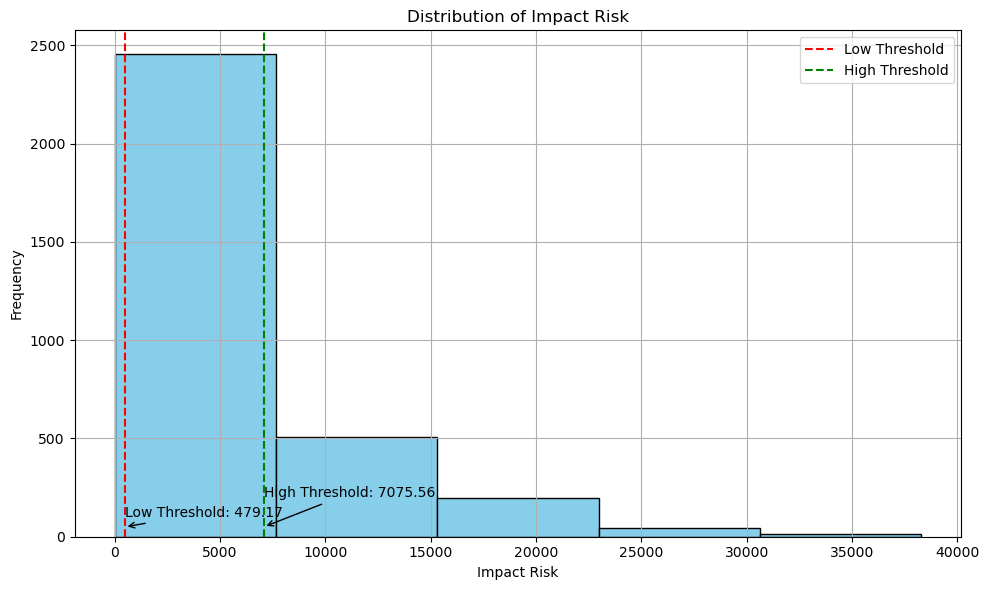

Low Threshold: 479.17470486772226
High Threshold: 7075.558111088614


In [9]:
oversampled_train['IMPACT_RISK'] = oversampled_train['EST_DIA_IN_M(MAX)'] * oversampled_train['RELATIVE_VELOCITY_KM_PER_SEC']

# Check the distribution of IMPACT RISK
risk_values = oversampled_train['IMPACT_RISK']
risk_values.describe()

# Determine thresholds based on the distribution
low_threshold = risk_values.quantile(0.25)
high_threshold = risk_values.quantile(0.75)

# Plotting the histogram with annotations for thresholds
plt.figure(figsize=(10, 6))
plt.hist(risk_values, bins=5, color='skyblue', edgecolor='black')
plt.axvline(low_threshold, color='r', linestyle='--', label='Low Threshold')
plt.axvline(high_threshold, color='g', linestyle='--', label='High Threshold')
plt.xlabel('Impact Risk')
plt.ylabel('Frequency')
plt.title('Distribution of Impact Risk')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Annotate the thresholds on the histogram
plt.annotate(f'Low Threshold: {low_threshold:.2f}', xy=(low_threshold, 50), xytext=(low_threshold + 5, 100),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate(f'High Threshold: {high_threshold:.2f}', xy=(high_threshold, 50), xytext=(high_threshold - 10, 200),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

print('Low Threshold:', low_threshold)
print('High Threshold:', high_threshold)

# Create a new column 'Impact Risk Category' based on calculated thresholds
oversampled_train['IMPACT_RISK_CATEGORY'] = pd.cut(oversampled_train['IMPACT_RISK'], bins=[-np.inf, low_threshold, high_threshold, np.inf],labels=['Low', 'Medium', 'High'])

In [10]:
# Encoding the target variable (IMPACT RISK CATEGORY)
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler

oversampled_train['IMPACT_RISK_ENCODED'] = le.fit_transform(oversampled_train['IMPACT_RISK_CATEGORY'])

# Convert Hazardous to encoded
oversampled_train['HAZARDOUS_ENCODED'] = oversampled_train['HAZARDOUS'].astype(int)

# Features and target preparation
X_oversampled = oversampled_train[['IMPACT_RISK','HAZARDOUS_ENCODED']]
y_oversampled = oversampled_train['IMPACT_RISK_ENCODED']

# Feature scaling
X_oversampled_scaled = scaler.fit_transform(X_oversampled)

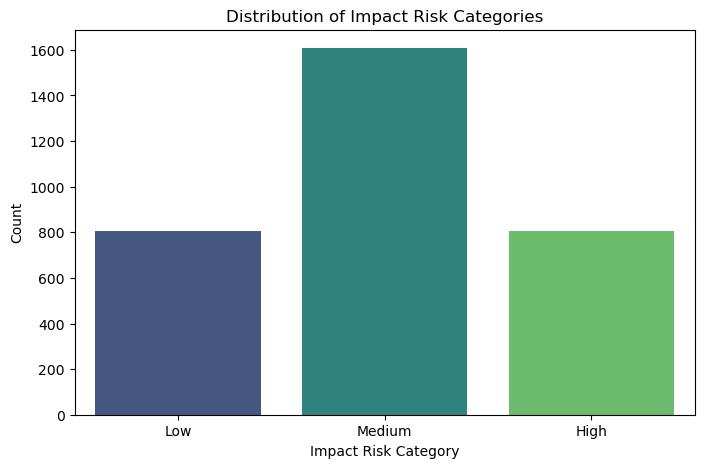

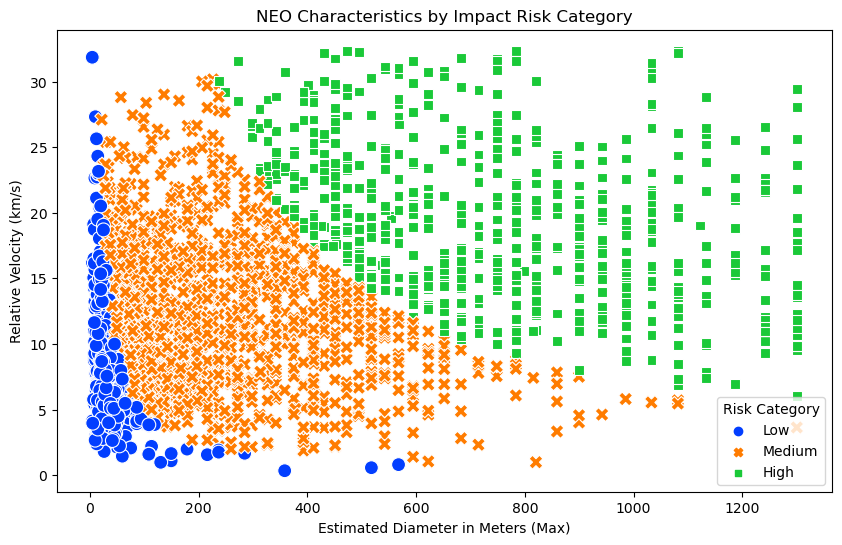

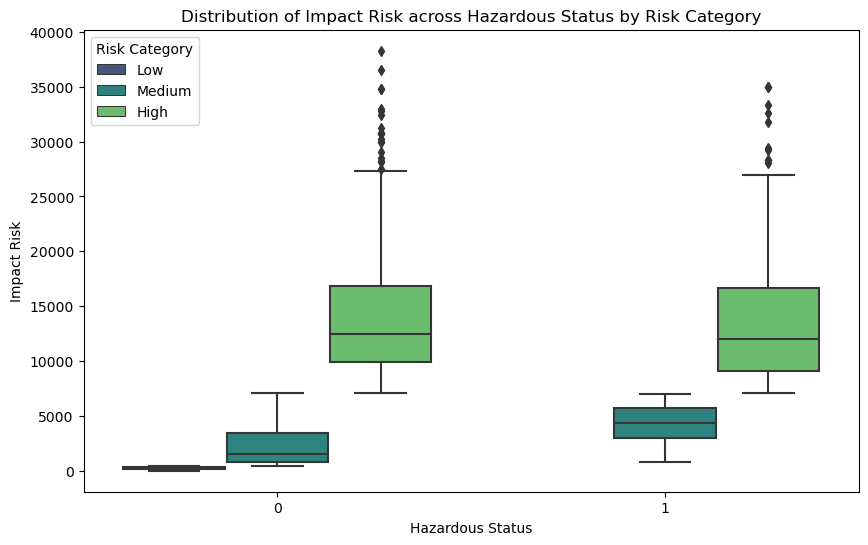

In [11]:
# Histogram of Impact Risk Categories
plt.figure(figsize=(8, 5))
sb.countplot(x='IMPACT_RISK_CATEGORY', data=oversampled_train, palette='viridis')
plt.title('Distribution of Impact Risk Categories')
plt.xlabel('Impact Risk Category')
plt.ylabel('Count')
plt.show()

# Scatter Plot with Categories
plt.figure(figsize=(10, 6))
sb.scatterplot(data=oversampled_train, x='EST_DIA_IN_M(MAX)', y='RELATIVE_VELOCITY_KM_PER_SEC', hue='IMPACT_RISK_CATEGORY', style='IMPACT_RISK_CATEGORY', palette='bright', s=100)
plt.title('NEO Characteristics by Impact Risk Category')
plt.xlabel('Estimated Diameter in Meters (Max)')
plt.ylabel('Relative Velocity (km/s)')
plt.legend(title='Risk Category')
plt.show()

# Box Plot with Categories
plt.figure(figsize=(10, 6))
sb.boxplot(x='HAZARDOUS_ENCODED', y='IMPACT_RISK', hue='IMPACT_RISK_CATEGORY', data=oversampled_train, palette='viridis')
plt.title('Distribution of Impact Risk across Hazardous Status by Risk Category')
plt.xlabel('Hazardous Status')
plt.ylabel('Impact Risk')
plt.legend(title='Risk Category')
plt.show()

## Importing Bootstrapping Data

In [12]:
#IMPORTING CLEANED TRAIN DATA USING BOOTSTRAP SAMPLING
bootstrapping_train = pd.read_csv("projectData/bootstrapping_train.csv", index_col = 0)
bootstrapping_train

,NEO_REFERENCE_ID,EST_DIA_IN_M(MIN),EST_DIA_IN_M(MAX),RELATIVE_VELOCITY_KM_PER_SEC,MISS_DIST.(KILOMETERS),PERIHELION_DISTANCE,APHELION_DIST,PERIHELION_TIME,MEAN_ANOMALY,MEAN_MOTION,HAZARDOUS,RISK_CATEGORY
0,3529625,183.888672,411.187571,9.551351,27837396.0,0.783714,1.338152,2457843.686,141.435423,0.901929,0.0,1
1,3256739,253.837029,567.596853,6.477856,72234080.0,1.239713,2.001073,2457878.935,58.087470,0.477830,0.0,1
2,3653520,69.912523,156.329154,24.300910,71082192.0,0.922122,3.114245,2457587.296,142.045632,0.343766,0.0,1
3,3071917,265.800000,594.346868,10.896092,33441924.0,1.163723,2.113338,2458007.502,356.709786,0.469918,0.0,1
4,3766293,23.150212,51.765448,13.348297,25744922.0,0.826214,1.215543,2457845.152,148.439096,0.955528,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3011,3455137,265.800000,594.346868,11.027074,39404808.0,0.601085,1.073320,2457864.451,175.046953,1.286644,1.0,2
3012,3626029,110.803882,247.765013,21.353475,64967668.0,0.562154,1.246986,2458122.294,220.469764,1.145621,1.0,2
3013,2140333,461.907460,1032.856481,23.062280,71000704.0,0.498651,1.425153,2457943.386,59.669559,1.044739,0.0,2
3014,3672899,127.219878,284.472297,12.747317,51848572.0,0.580992,1.433941,2457777.421,187.560356,0.974671,1.0,2


## Classification of Bootstrapping Train by Logistic Regression

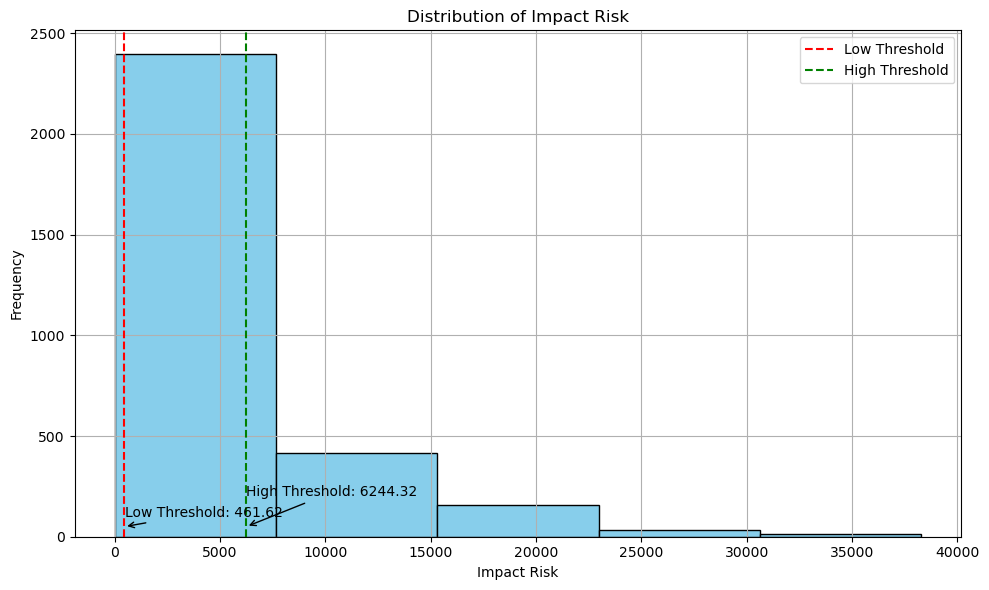

Low Threshold: 461.6232968152039
High Threshold: 6244.324294379966


In [13]:
bootstrapping_train['IMPACT_RISK'] = bootstrapping_train['EST_DIA_IN_M(MAX)'] * bootstrapping_train['RELATIVE_VELOCITY_KM_PER_SEC']

# Check the distribution of IMPACT RISK
risk_values = bootstrapping_train['IMPACT_RISK']
risk_values.describe()

# Determine thresholds based on the distribution
low_threshold = risk_values.quantile(0.25)
high_threshold = risk_values.quantile(0.75)

# Plotting the histogram with annotations for thresholds
plt.figure(figsize=(10, 6))
plt.hist(risk_values, bins=5, color='skyblue', edgecolor='black')
plt.axvline(low_threshold, color='r', linestyle='--', label='Low Threshold')
plt.axvline(high_threshold, color='g', linestyle='--', label='High Threshold')
plt.xlabel('Impact Risk')
plt.ylabel('Frequency')
plt.title('Distribution of Impact Risk')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Annotate the thresholds on the histogram
plt.annotate(f'Low Threshold: {low_threshold:.2f}', xy=(low_threshold, 50), xytext=(low_threshold + 5, 100),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate(f'High Threshold: {high_threshold:.2f}', xy=(high_threshold, 50), xytext=(high_threshold - 10, 200),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

print('Low Threshold:', low_threshold)
print('High Threshold:', high_threshold)

# Create a new column 'Impact Risk Category' based on calculated thresholds
bootstrapping_train['IMPACT_RISK_CATEGORY'] = pd.cut(bootstrapping_train['IMPACT_RISK'], bins=[-np.inf, low_threshold, high_threshold, np.inf],labels=['Low', 'Medium', 'High'])

In [14]:
# Encoding the target variable (IMPACT RISK CATEGORY)
bootstrapping_train['IMPACT_RISK_ENCODED'] = le.fit_transform(bootstrapping_train['IMPACT_RISK_CATEGORY'])

# Convert Hazardous to encoded
bootstrapping_train['HAZARDOUS_ENCODED'] = bootstrapping_train['HAZARDOUS'].astype(int)

# Features and target preparation
X_bootstrapped = bootstrapping_train[['IMPACT_RISK','HAZARDOUS_ENCODED']]
y_bootstrapped = bootstrapping_train['IMPACT_RISK_ENCODED']

# Feature scaling
X_bootstrapped_scaled = scaler.fit_transform(X_bootstrapped)

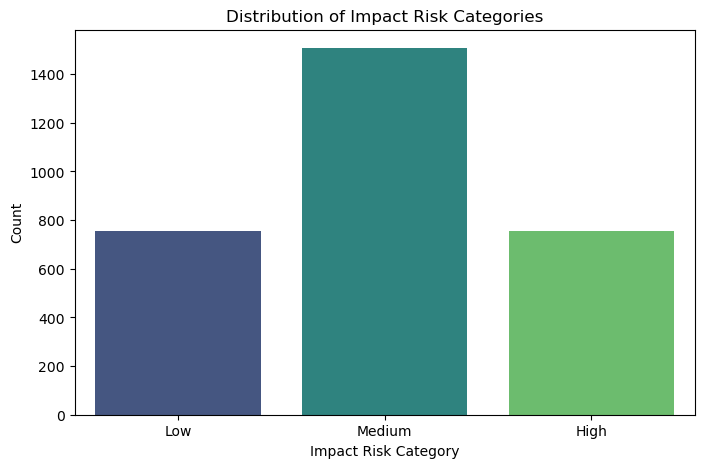

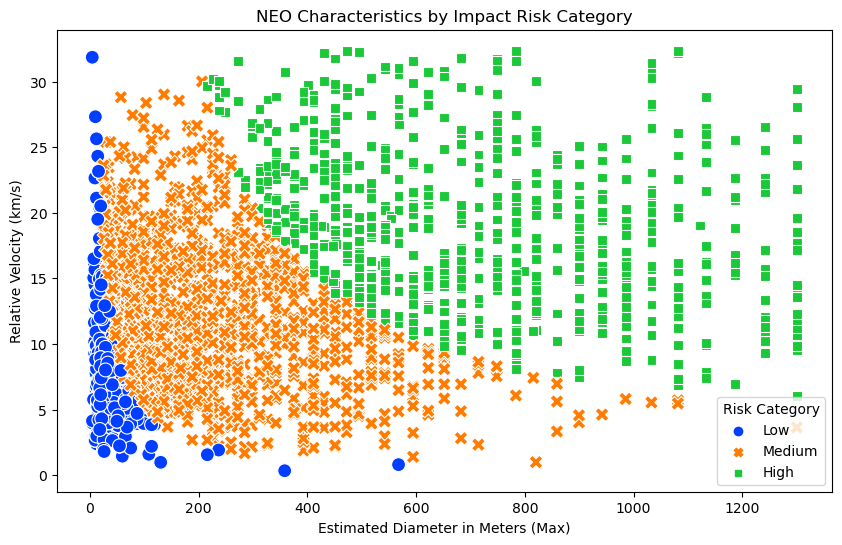

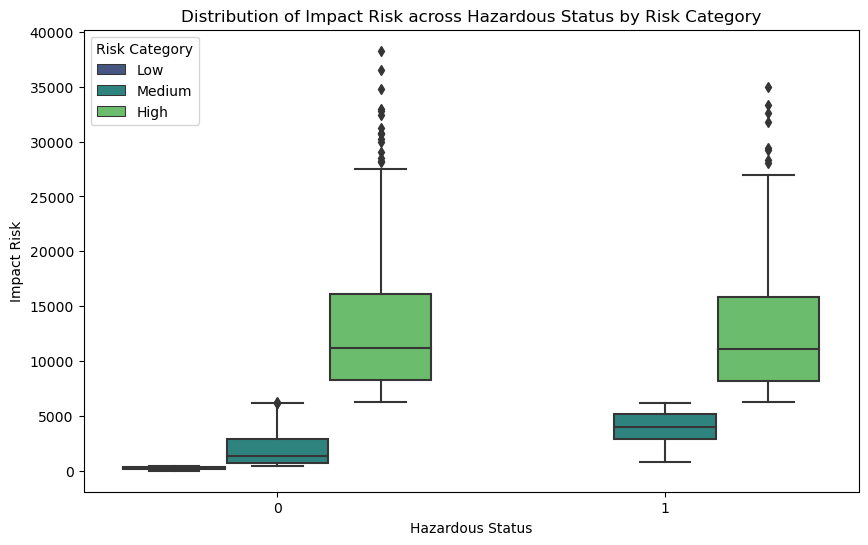

In [15]:
# Histogram of Impact Risk Categories
plt.figure(figsize=(8, 5))
sb.countplot(x='IMPACT_RISK_CATEGORY', data=bootstrapping_train, palette='viridis')
plt.title('Distribution of Impact Risk Categories')
plt.xlabel('Impact Risk Category')
plt.ylabel('Count')
plt.show()

# Scatter Plot with Categories
plt.figure(figsize=(10, 6))
sb.scatterplot(data=bootstrapping_train, x='EST_DIA_IN_M(MAX)', y='RELATIVE_VELOCITY_KM_PER_SEC', hue='IMPACT_RISK_CATEGORY', style='IMPACT_RISK_CATEGORY', palette='bright', s=100)
plt.title('NEO Characteristics by Impact Risk Category')
plt.xlabel('Estimated Diameter in Meters (Max)')
plt.ylabel('Relative Velocity (km/s)')
plt.legend(title='Risk Category')
plt.show()

# Box Plot with Categories
plt.figure(figsize=(10, 6))
sb.boxplot(x='HAZARDOUS_ENCODED', y='IMPACT_RISK', hue='IMPACT_RISK_CATEGORY', data=bootstrapping_train, palette='viridis')
plt.title('Distribution of Impact Risk across Hazardous Status by Risk Category')
plt.xlabel('Hazardous Status')
plt.ylabel('Impact Risk')
plt.legend(title='Risk Category')
plt.show()

## Importing Smotetomek Data

In [16]:
#IMPORTING CLEANED TRAIN DATA USING SMOTETOMEK SAMPLING
smotetomek_train= pd.read_csv("projectData/smotetomek_train.csv", index_col = 0)
smotetomek_train

,NEO_REFERENCE_ID,EST_DIA_IN_M(MIN),EST_DIA_IN_M(MAX),RELATIVE_VELOCITY_KM_PER_SEC,MISS_DIST.(KILOMETERS),PERIHELION_DISTANCE,APHELION_DIST,PERIHELION_TIME,MEAN_ANOMALY,MEAN_MOTION,HAZARDOUS,RISK_CATEGORY
0,3182169,50.647146,113.250461,3.838017,1.293793e+07,0.894596,1.275511,2.458020e+06,343.278084,0.872021,0,0
1,3256739,253.837029,567.596853,6.477856,7.223408e+07,1.239713,2.001073,2.457879e+06,58.087470,0.477830,0,1
2,3761549,334.622374,748.238376,18.027267,2.581880e+07,0.993025,1.966328,2.458314e+06,188.533899,0.547588,1,2
3,3653520,69.912523,156.329154,24.300910,7.108219e+07,0.922122,3.114245,2.457587e+06,142.045632,0.343766,0,1
4,3071917,265.800000,594.346868,10.896092,3.344192e+07,1.163723,2.113338,2.458008e+06,356.709786,0.469918,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2411,2837673,144.190934,322.420730,16.066831,6.386033e+06,0.593617,2.090824,2.457922e+06,150.761198,0.779735,1,2
2412,3683281,182.453909,407.979344,28.224700,4.296565e+07,0.876687,1.809730,2.458091e+06,263.878472,0.652860,0,2
2413,3631831,393.797834,880.558727,13.826735,6.691404e+06,0.662447,1.680256,2.458160e+06,261.203582,0.981196,1,2
2414,3729414,198.211484,443.214353,23.729151,3.797147e+07,0.656363,2.551615,2.458099e+06,310.652510,0.485534,0,2


## Classification of Smotetomek Train by Logistic Regression

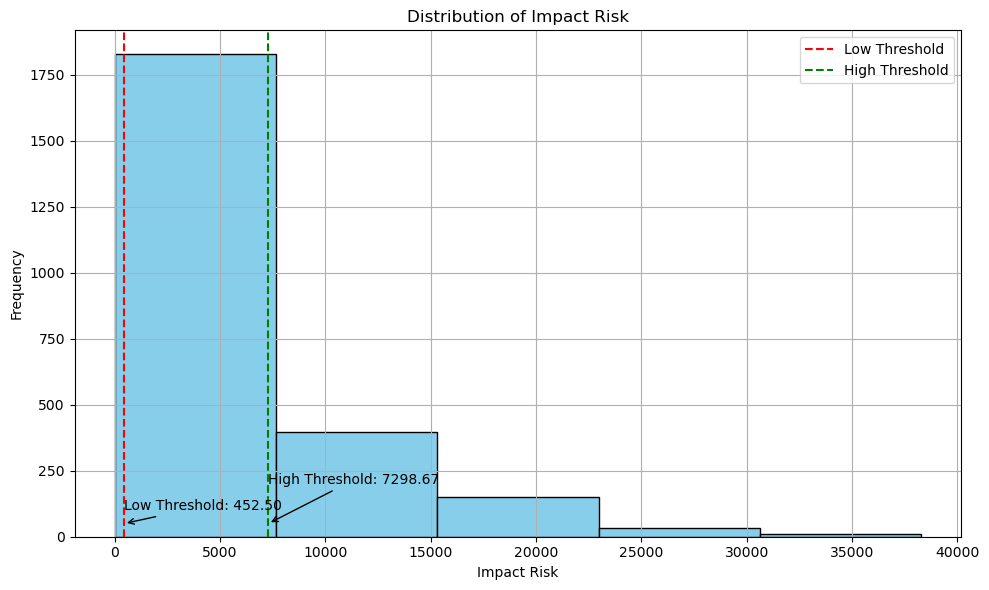

Low Threshold: 452.49731830343205
High Threshold: 7298.666318419686


In [17]:
smotetomek_train['IMPACT_RISK'] = smotetomek_train['EST_DIA_IN_M(MAX)'] * smotetomek_train['RELATIVE_VELOCITY_KM_PER_SEC']

# Check the distribution of IMPACT RISK
risk_values = smotetomek_train['IMPACT_RISK']
risk_values.describe()

# Determine thresholds based on the distribution
low_threshold = risk_values.quantile(0.25)
high_threshold = risk_values.quantile(0.75)

# Plotting the histogram with annotations for thresholds
plt.figure(figsize=(10, 6))
plt.hist(risk_values, bins=5, color='skyblue', edgecolor='black')
plt.axvline(low_threshold, color='r', linestyle='--', label='Low Threshold')
plt.axvline(high_threshold, color='g', linestyle='--', label='High Threshold')
plt.xlabel('Impact Risk')
plt.ylabel('Frequency')
plt.title('Distribution of Impact Risk')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Annotate the thresholds on the histogram
plt.annotate(f'Low Threshold: {low_threshold:.2f}', xy=(low_threshold, 50), xytext=(low_threshold + 5, 100),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate(f'High Threshold: {high_threshold:.2f}', xy=(high_threshold, 50), xytext=(high_threshold - 10, 200),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()

print('Low Threshold:', low_threshold)
print('High Threshold:', high_threshold)

# Create a new column 'Impact Risk Category' based on calculated thresholds
smotetomek_train['IMPACT_RISK_CATEGORY'] = pd.cut(smotetomek_train['IMPACT_RISK'], bins=[-np.inf, low_threshold, high_threshold, np.inf],labels=['Low', 'Medium', 'High'])

In [18]:
# Encoding the target variable (IMPACT RISK CATEGORY)
smotetomek_train['IMPACT_RISK_ENCODED'] = le.fit_transform(smotetomek_train['IMPACT_RISK_CATEGORY'])

# Convert Hazardous to encoded
smotetomek_train['HAZARDOUS_ENCODED'] = smotetomek_train['HAZARDOUS'].astype(int)

# Features and target preparation
X_smotetomek = smotetomek_train[['IMPACT_RISK','HAZARDOUS_ENCODED']]
y_smotetomek = smotetomek_train['IMPACT_RISK_ENCODED']

# Feature scaling
X_smotetomek_scaled = scaler.fit_transform(X_smotetomek)

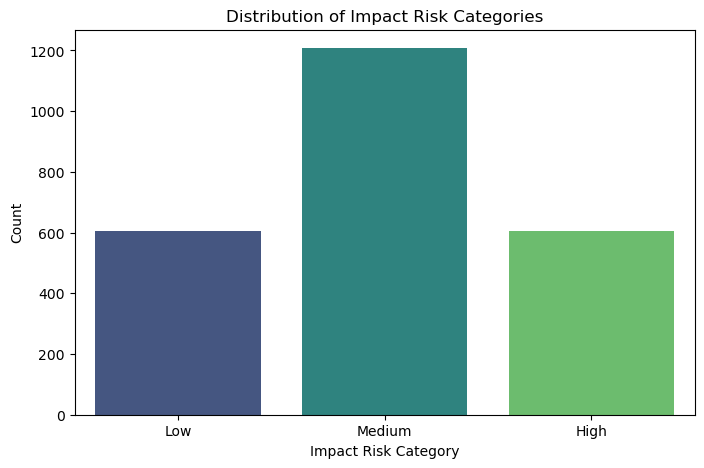

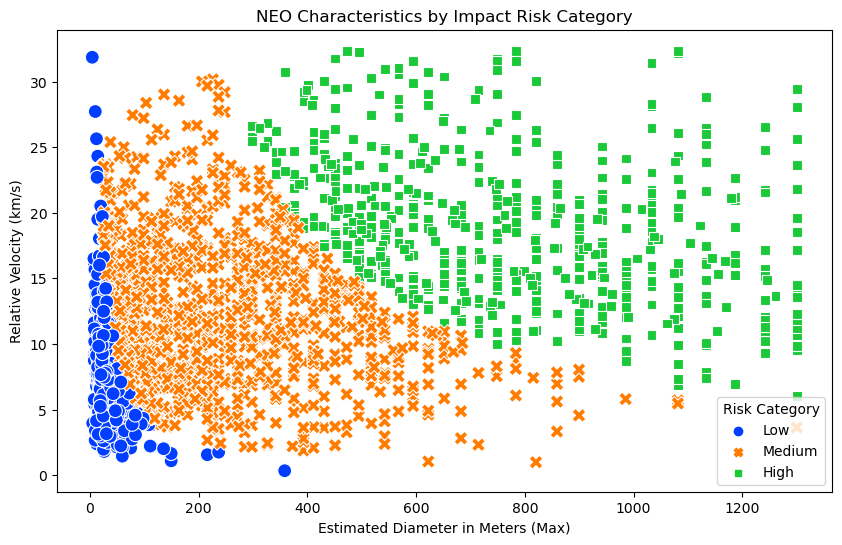

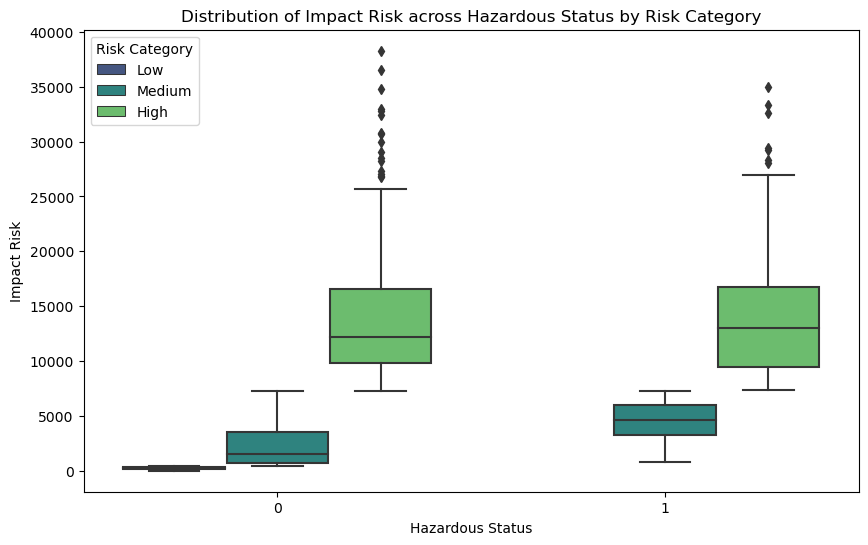

In [19]:
# Histogram of Impact Risk Categories
plt.figure(figsize=(8, 5))
sb.countplot(x='IMPACT_RISK_CATEGORY', data=smotetomek_train, palette='viridis')
plt.title('Distribution of Impact Risk Categories')
plt.xlabel('Impact Risk Category')
plt.ylabel('Count')
plt.show()

# Scatter Plot with Categories
plt.figure(figsize=(10, 6))
sb.scatterplot(data=smotetomek_train, x='EST_DIA_IN_M(MAX)', y='RELATIVE_VELOCITY_KM_PER_SEC', hue='IMPACT_RISK_CATEGORY', style='IMPACT_RISK_CATEGORY', palette='bright', s=100)
plt.title('NEO Characteristics by Impact Risk Category')
plt.xlabel('Estimated Diameter in Meters (Max)')
plt.ylabel('Relative Velocity (km/s)')
plt.legend(title='Risk Category')
plt.show()

# Box Plot with Categories
plt.figure(figsize=(10, 6))
sb.boxplot(x='HAZARDOUS_ENCODED', y='IMPACT_RISK', hue='IMPACT_RISK_CATEGORY', data=smotetomek_train, palette='viridis')
plt.title('Distribution of Impact Risk across Hazardous Status by Risk Category')
plt.xlabel('Hazardous Status')
plt.ylabel('Impact Risk')
plt.legend(title='Risk Category')
plt.show()

## Logistic Regression

In [20]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Train with original data
model.fit(X_scaled, y)
predictions_original = model.predict(X_scaled)

# Train with oversampled data
model.fit(X_oversampled_scaled, y_oversampled)
predictions_oversampled = model.predict(X_oversampled_scaled)

# Train with bootstrapped data
model.fit(X_bootstrapped_scaled, y_bootstrapped)
predictions_bootstrap = model.predict(X_bootstrapped_scaled)

# Train with smotetomek data
model.fit(X_smotetomek_scaled, y_smotetomek)
predictions_smotetomek = model.predict(X_smotetomek_scaled)

In [21]:
def plot_confusion_matrix(y_true, y_pred, title):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Use Seaborn to create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sb.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [22]:
# Evaluation Metrics
def evaluate_predictions(y_true, y_pred, dataset_type):
    print(f"Results for {dataset_type} Dataset:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("F1-Score:", f1_score(y_true, y_pred, average='weighted'))
    print()

# Evaluate both models
evaluate_predictions(y, predictions_original, 'Original')
evaluate_predictions(y_oversampled, predictions_oversampled, 'Oversampled')
evaluate_predictions(y_bootstrapped, predictions_bootstrap, 'Bootstrapped')
evaluate_predictions(y_smotetomek, predictions_smotetomek, 'Smotetomek')

Results for Original Dataset:
Accuracy: 0.9692780337941628
Precision: 0.9713874476987447
Recall: 0.9692780337941628
F1-Score: 0.9695472239956578

Results for Oversampled Dataset:
Accuracy: 0.9493159203980099
Precision: 0.955619382537962
Recall: 0.9493159203980099
F1-Score: 0.9500958817844682

Results for Bootstrapped Dataset:
Accuracy: 0.9618700265251989
Precision: 0.9656246967494898
Recall: 0.9618700265251989
F1-Score: 0.9623411647074598

Results for Smotetomek Dataset:
Accuracy: 0.9461920529801324
Precision: 0.9543326735864545
Recall: 0.9461920529801324
F1-Score: 0.9471646862595237



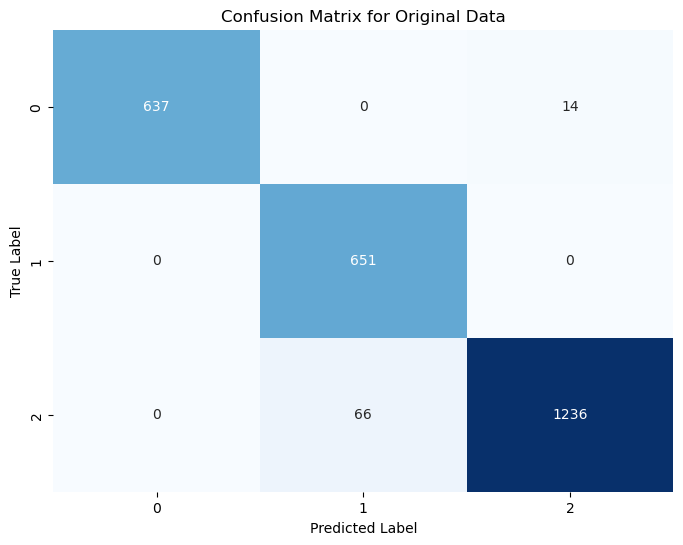

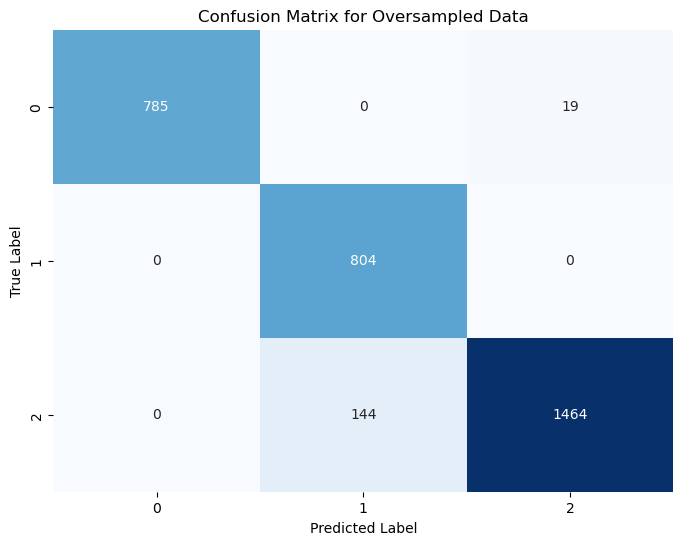

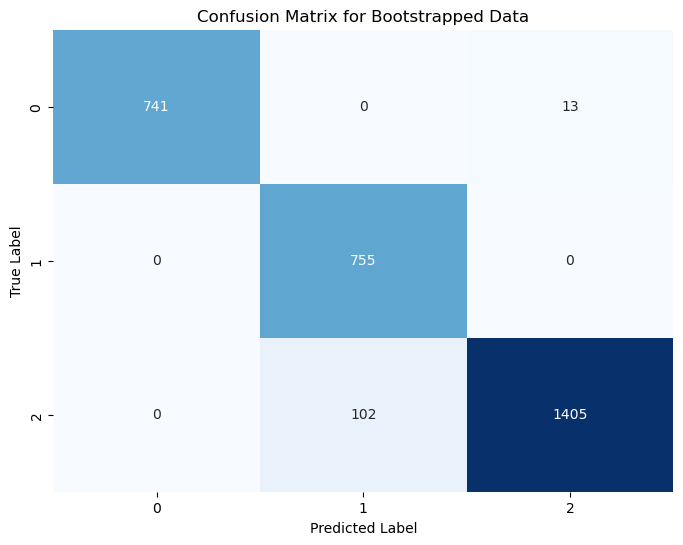

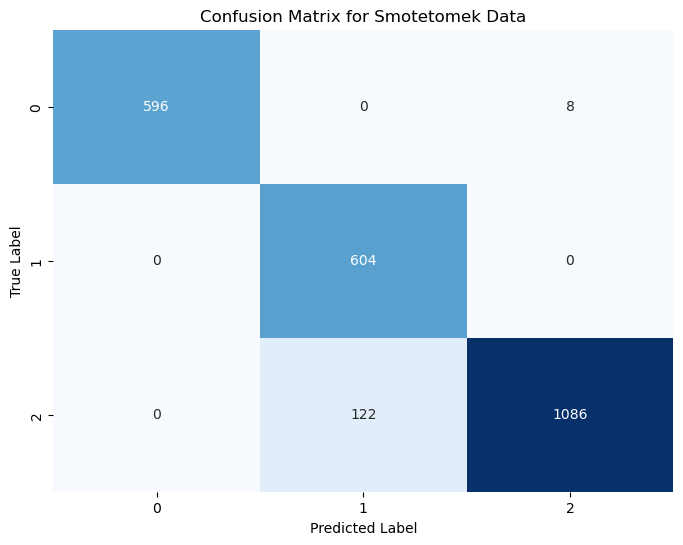

In [23]:
plot_confusion_matrix(y, predictions_original, 'Confusion Matrix for Original Data')
plot_confusion_matrix(y_oversampled, predictions_oversampled, 'Confusion Matrix for Oversampled Data')
plot_confusion_matrix(y_bootstrapped, predictions_bootstrap, 'Confusion Matrix for Bootstrapped Data')
plot_confusion_matrix(y_smotetomek, predictions_smotetomek, 'Confusion Matrix for Smotetomek Data')

In [29]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(X, y, estimator, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes, scoring='accuracy'
    )
    
    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    
    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Plot the learning curve
    plt.subplots(1, 1, figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy Score')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

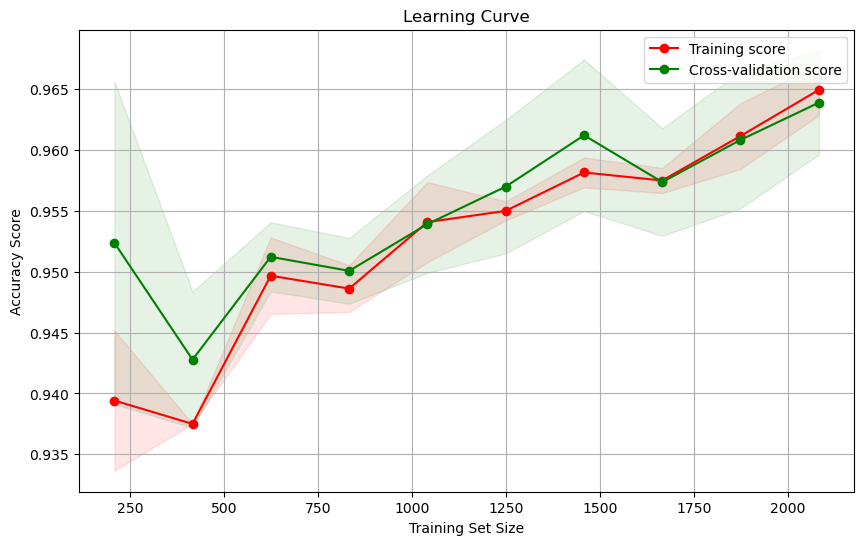

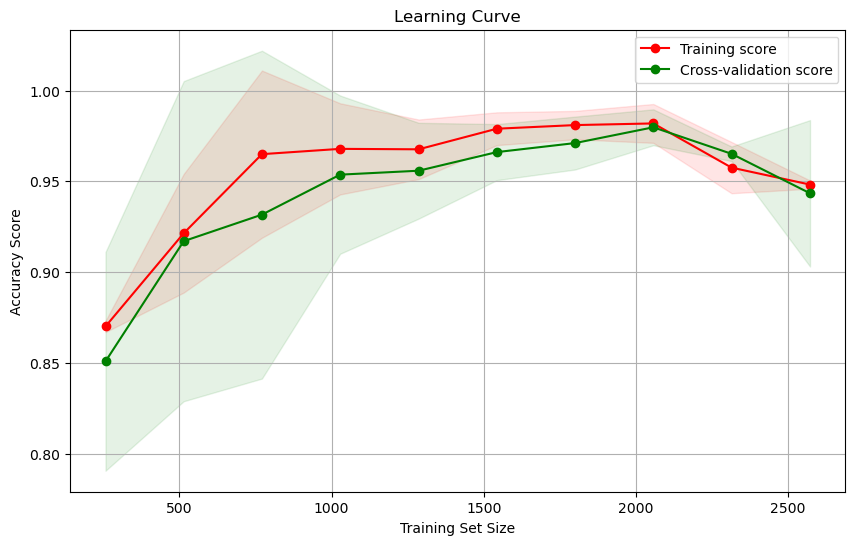

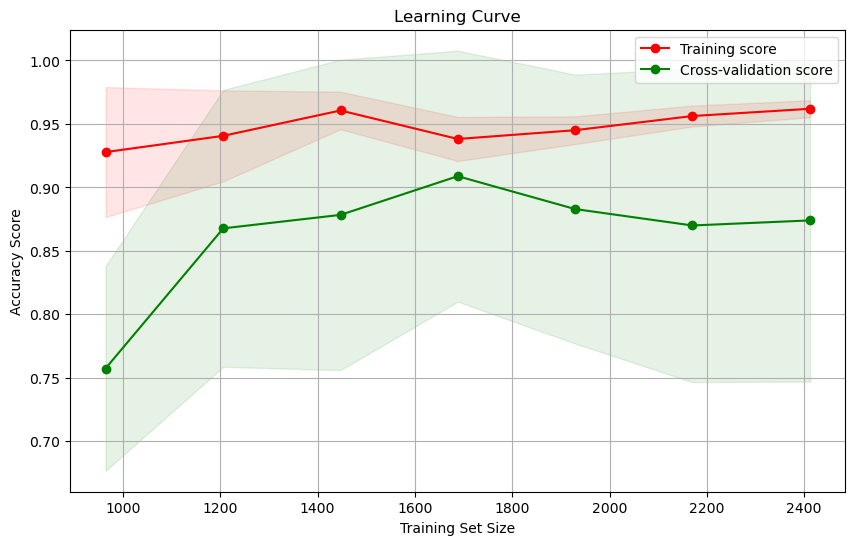

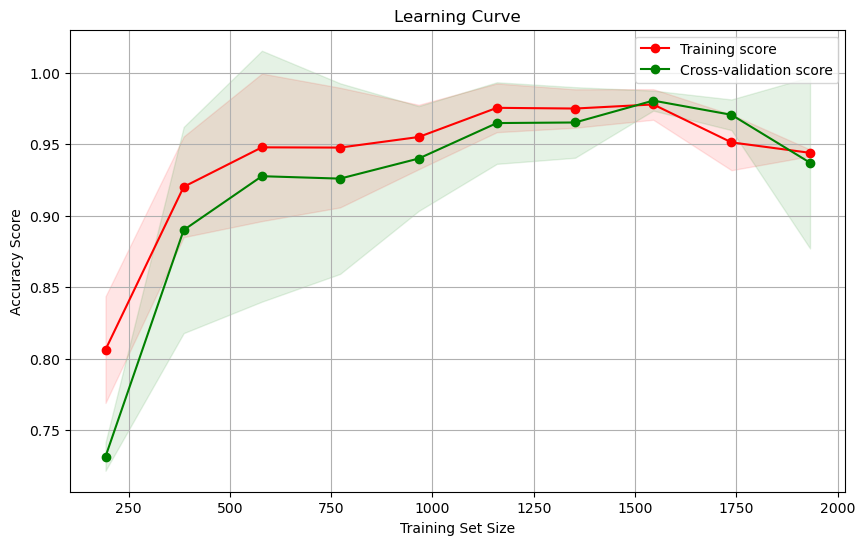

In [32]:
plot_learning_curve(X_scaled, y, model)
plot_learning_curve(X_oversampled_scaled, y_oversampled, model)
plot_learning_curve(X_bootstrapped_scaled, y_bootstrapped, model)
plot_learning_curve(X_smotetomek_scaled, y_smotetomek, model)